## AST Model with Regular Labels

### Libraries

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.optim import Adam
from transformers import ASTConfig, ASTModel
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import pickle
from tqdm.notebook import tqdm


/home/chijuiwu/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


### Import the MFCC and Spectrogram, Processing

In [2]:
# Load the MFCC dataset
with open('mfcc_dataset.pkl', 'rb') as mfcc_file:
    mfcc_dataset = pickle.load(mfcc_file)
    
# Load the spectrogram dataset
with open('spectrogram_dataset.pkl', 'rb') as spectrogram_file:
    spectrogram_dataset = pickle.load(spectrogram_file)
    


In [3]:
print(spectrogram_dataset[0])


{'file_id': 'W1XD0EGO', 'sample_rate': 16000, 'start_sec': 0, 'end_sec': 1, 'spectrogram': array([[-8.287623 , -8.287623 , -8.287623 , ..., -2.829914 , -2.9057107,
        -2.9057107],
       [-8.287623 , -8.287623 , -8.287623 , ..., -2.9327095, -2.9627967,
        -2.9627967],
       [-8.287623 , -8.287623 , -8.287623 , ..., -3.37057  , -3.3034296,
        -3.3034296],
       ...,
       [-8.287623 , -8.287623 , -8.287623 , ..., -8.287623 , -8.287623 ,
        -8.287623 ],
       [-8.287623 , -8.287623 , -8.287623 , ..., -8.287623 , -8.287623 ,
        -8.287623 ],
       [-8.287623 , -8.287623 , -8.287623 , ..., -8.281083 , -8.2801485,
        -8.2801485]], dtype=float32), 'action': 'c115'}


In [4]:
class_distribution = {}
for item in spectrogram_dataset:
    action = item['action']
    if action in class_distribution:
        class_distribution[action] += 1
    else:
        class_distribution[action] = 1

class_distribution_sorted = dict(sorted(class_distribution.items(), key=lambda item: item[1], reverse=True))

print(class_distribution_sorted)

{'no_action': 23256, 'c154': 3101, 'c059': 2886, 'c151': 2108, 'c107': 2103, 'c061': 2044, 'c011': 1935, 'c152': 1701, 'c015': 1520, 'c097': 1516, 'c106': 1441, 'c156': 1416, 'c009': 1341, 'c118': 1308, 'c127': 1284, 'c063': 1245, 'c016': 1172, 'c026': 1166, 'c000': 1158, 'c033': 1157, 'c110': 1124, 'c125': 1114, 'c135': 1109, 'c123': 1089, 'c032': 1035, 'c109': 1004, 'c149': 1003, 'c008': 958, 'c115': 941, 'c132': 937, 'c062': 927, 'c020': 909, 'c113': 895, 'c141': 891, 'c070': 844, 'c001': 839, 'c006': 813, 'c098': 788, 'c038': 777, 'c119': 764, 'c002': 751, 'c147': 743, 'c014': 723, 'c065': 697, 'c126': 687, 'c076': 686, 'c051': 681, 'c081': 673, 'c096': 669, 'c040': 664, 'c102': 659, 'c153': 655, 'c012': 640, 'c004': 637, 'c112': 612, 'c052': 604, 'c145': 600, 'c120': 596, 'c021': 572, 'c134': 564, 'c146': 561, 'c114': 551, 'c067': 527, 'c155': 526, 'c034': 525, 'c035': 524, 'c030': 505, 'c137': 498, 'c037': 490, 'c054': 482, 'c082': 455, 'c150': 446, 'c071': 445, 'c017': 445, 'c08

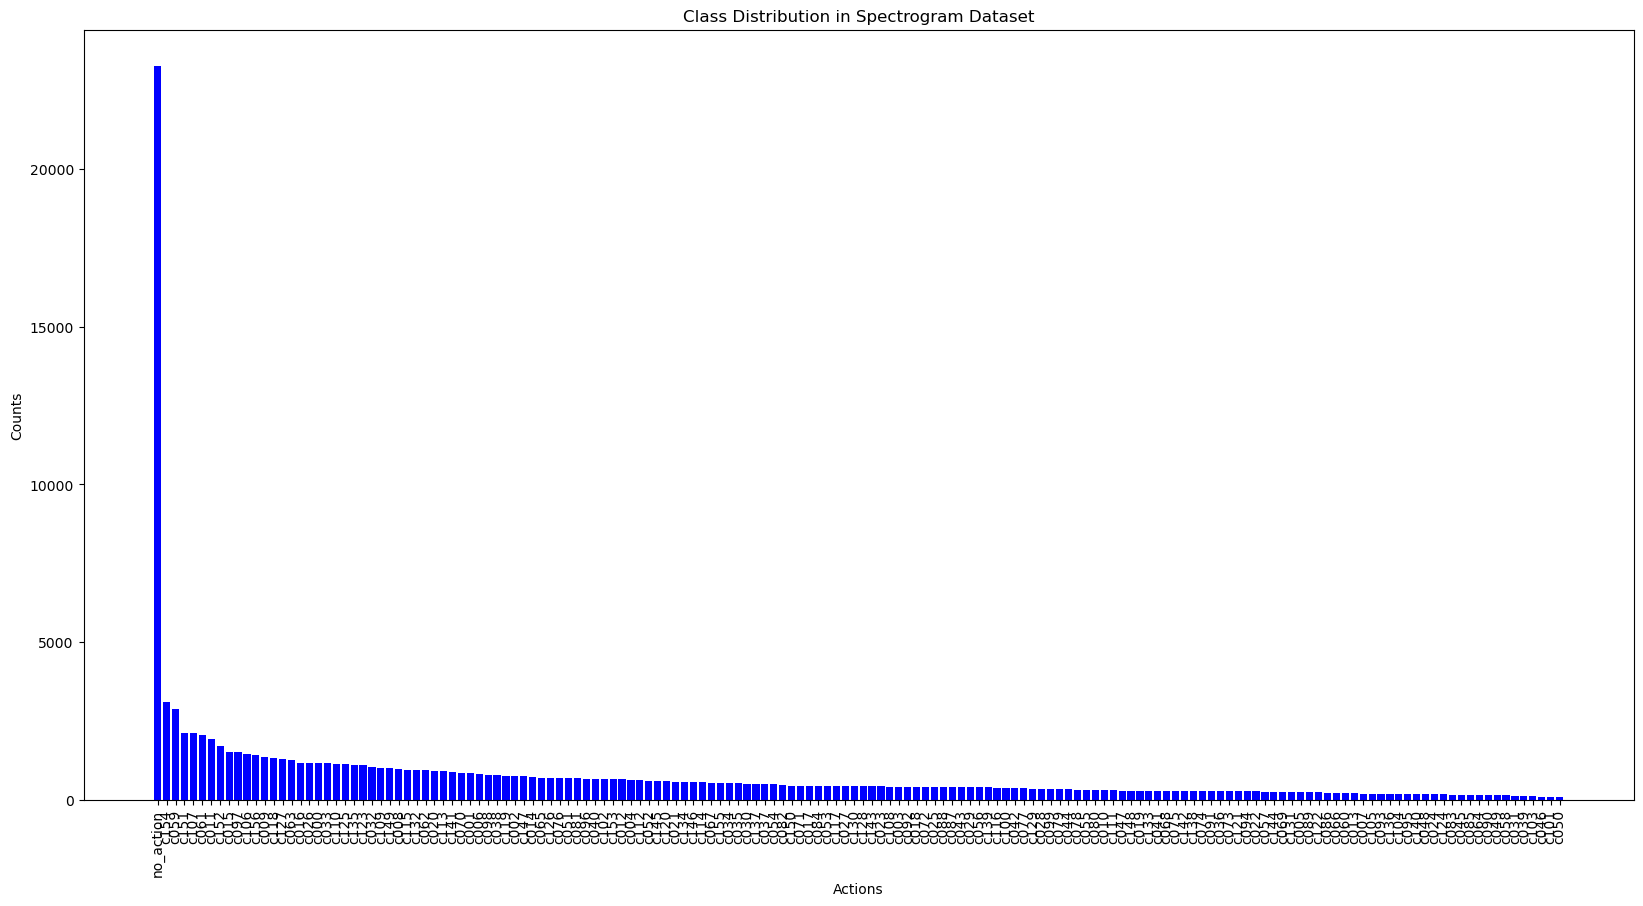

In [5]:


# Extracting keys and values for plotting
actions = list(class_distribution_sorted.keys())
counts = list(class_distribution_sorted.values())

# Creating the bar plot
plt.figure(figsize=(20, 10))  # Adjust the size as needed
plt.bar(actions, counts, color='blue')
plt.xlabel('Actions')
plt.ylabel('Counts')
plt.title('Class Distribution in Spectrogram Dataset')
plt.xticks(rotation=90)  # Rotates the x labels to prevent overlap
plt.show()


In [6]:
unique_labels = set()

for item in spectrogram_dataset:
    action = item['action']
    unique_labels.add(action)

sorted_labels = sorted(unique_labels)
print(sorted_labels)

['c000', 'c001', 'c002', 'c003', 'c004', 'c005', 'c006', 'c007', 'c008', 'c009', 'c010', 'c011', 'c012', 'c013', 'c014', 'c015', 'c016', 'c017', 'c018', 'c019', 'c020', 'c021', 'c022', 'c023', 'c024', 'c025', 'c026', 'c027', 'c028', 'c029', 'c030', 'c031', 'c032', 'c033', 'c034', 'c035', 'c036', 'c037', 'c038', 'c039', 'c040', 'c041', 'c042', 'c043', 'c044', 'c045', 'c046', 'c047', 'c048', 'c049', 'c050', 'c051', 'c052', 'c053', 'c054', 'c055', 'c056', 'c057', 'c058', 'c059', 'c060', 'c061', 'c062', 'c063', 'c064', 'c065', 'c066', 'c067', 'c068', 'c069', 'c070', 'c071', 'c072', 'c073', 'c074', 'c075', 'c076', 'c077', 'c078', 'c079', 'c080', 'c081', 'c082', 'c083', 'c084', 'c085', 'c086', 'c087', 'c088', 'c089', 'c090', 'c091', 'c092', 'c093', 'c094', 'c095', 'c096', 'c097', 'c098', 'c099', 'c100', 'c101', 'c102', 'c103', 'c104', 'c105', 'c106', 'c107', 'c108', 'c109', 'c110', 'c111', 'c112', 'c113', 'c114', 'c115', 'c116', 'c117', 'c118', 'c119', 'c120', 'c121', 'c122', 'c123', 'c124',

In [7]:
num_classes = len(sorted_labels)
print(num_classes)

158


In [8]:
label_to_int = {label: i for i, label in enumerate(sorted_labels)}
print(label_to_int)

{'c000': 0, 'c001': 1, 'c002': 2, 'c003': 3, 'c004': 4, 'c005': 5, 'c006': 6, 'c007': 7, 'c008': 8, 'c009': 9, 'c010': 10, 'c011': 11, 'c012': 12, 'c013': 13, 'c014': 14, 'c015': 15, 'c016': 16, 'c017': 17, 'c018': 18, 'c019': 19, 'c020': 20, 'c021': 21, 'c022': 22, 'c023': 23, 'c024': 24, 'c025': 25, 'c026': 26, 'c027': 27, 'c028': 28, 'c029': 29, 'c030': 30, 'c031': 31, 'c032': 32, 'c033': 33, 'c034': 34, 'c035': 35, 'c036': 36, 'c037': 37, 'c038': 38, 'c039': 39, 'c040': 40, 'c041': 41, 'c042': 42, 'c043': 43, 'c044': 44, 'c045': 45, 'c046': 46, 'c047': 47, 'c048': 48, 'c049': 49, 'c050': 50, 'c051': 51, 'c052': 52, 'c053': 53, 'c054': 54, 'c055': 55, 'c056': 56, 'c057': 57, 'c058': 58, 'c059': 59, 'c060': 60, 'c061': 61, 'c062': 62, 'c063': 63, 'c064': 64, 'c065': 65, 'c066': 66, 'c067': 67, 'c068': 68, 'c069': 69, 'c070': 70, 'c071': 71, 'c072': 72, 'c073': 73, 'c074': 74, 'c075': 75, 'c076': 76, 'c077': 77, 'c078': 78, 'c079': 79, 'c080': 80, 'c081': 81, 'c082': 82, 'c083': 83, '

In [9]:
# Calculate the total number of samples
total_samples = sum(class_distribution_sorted.values())

# Calculate class weights
class_weights = {class_label: 1.0 - (count / total_samples)
                 for class_label, count in class_distribution_sorted.items()}

# Create a list of weights in the order of sorted labels
weights = [class_weights[label] for label in sorted_labels]

In [10]:
print(total_samples)

116873


In [11]:
# Convert the list of weights to a tensor
weight_tensor = torch.FloatTensor(weights)

print(weight_tensor)

tensor([0.9901, 0.9928, 0.9936, 0.9965, 0.9945, 0.9979, 0.9930, 0.9984, 0.9918,
        0.9885, 0.9975, 0.9834, 0.9945, 0.9983, 0.9938, 0.9870, 0.9900, 0.9962,
        0.9965, 0.9976, 0.9922, 0.9951, 0.9978, 0.9964, 0.9986, 0.9966, 0.9900,
        0.9962, 0.9972, 0.9967, 0.9957, 0.9989, 0.9911, 0.9901, 0.9955, 0.9955,
        0.9977, 0.9958, 0.9934, 0.9990, 0.9943, 0.9976, 0.9968, 0.9966, 0.9973,
        0.9986, 0.9993, 0.9976, 0.9986, 0.9988, 0.9993, 0.9942, 0.9948, 0.9962,
        0.9959, 0.9973, 0.9967, 0.9979, 0.9989, 0.9753, 0.9982, 0.9825, 0.9921,
        0.9893, 0.9987, 0.9940, 0.9981, 0.9955, 0.9977, 0.9979, 0.9928, 0.9962,
        0.9966, 0.9977, 0.9977, 0.9977, 0.9941, 0.9969, 0.9973, 0.9972, 0.9975,
        0.9942, 0.9961, 0.9986, 0.9962, 0.9987, 0.9981, 0.9966, 0.9966, 0.9980,
        0.9987, 0.9977, 0.9965, 0.9984, 0.9978, 0.9985, 0.9943, 0.9870, 0.9933,
        0.9972, 0.9968, 0.9993, 0.9944, 0.9991, 0.9985, 0.9984, 0.9877, 0.9820,
        0.9965, 0.9914, 0.9904, 0.9975, 

In [12]:
# First split: 80% Train, 20% Temp (which will be split into validation and test)
train_set, temp_set = train_test_split(spectrogram_dataset, test_size=0.2, random_state=42)

# Second split: Split the Temp set into 50% Validation, 50% Test
val_set, test_set = train_test_split(temp_set, test_size=0.5, random_state=42)

# Get the number of samples in each set
num_train_samples = len(train_set)
num_val_samples = len(val_set)
num_test_samples = len(test_set)

print("Number of training samples:", num_train_samples)
print("Number of validation samples:", num_val_samples)
print("Number of testing samples:", num_test_samples)

Number of training samples: 93498
Number of validation samples: 11687
Number of testing samples: 11688


In [13]:
custom_config = ASTConfig(
    hidden_act="sigmoid",
    hidden_size=768,
    num_hidden_layers=6,
    num_attention_heads=6,
    intermediate_size=3072,
    hidden_dropout_prob=0.0,
    attention_probs_dropout_prob=0.0,
    initializer_range=0.02,
    layer_norm_eps=1e-12,
    patch_size=16,
    qkv_bias=True,
    frequency_stride=10,
    max_length=1024,
    num_mel_bins=128,
    time_stride=10,
)

In [14]:
configuration = custom_config

model = ASTModel(configuration)

# Accessing the model configuration

configuration = model.config

In [15]:
print(configuration)

ASTConfig {
  "attention_probs_dropout_prob": 0.0,
  "frequency_stride": 10,
  "hidden_act": "sigmoid",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_length": 1024,
  "model_type": "audio-spectrogram-transformer",
  "num_attention_heads": 6,
  "num_hidden_layers": 6,
  "num_mel_bins": 128,
  "patch_size": 16,
  "qkv_bias": true,
  "time_stride": 10,
  "transformers_version": "4.32.1"
}



In [16]:
batch_size = 32

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [17]:
model = ASTModel(config=ASTConfig())
final_layer = nn.Linear(768, num_classes)

if torch.cuda.is_available():
    model = model.cuda()
    final_layer = final_layer.cuda()

optimizer = Adam(list(model.parameters()) + list(final_layer.parameters()), lr=1e-3)

# Initialize the loss function with weights
loss_fn = torch.nn.CrossEntropyLoss(weight=weight_tensor)


In [18]:
num_epochs = 15
num_classes = len(label_to_int)  

final_layer = nn.Linear(768, num_classes)

if torch.cuda.is_available():
    weight_tensor = weight_tensor.cuda()

# Initialize dictionaries to track correct and total counts per class for both training and validation
correct_per_class_train = {class_id: 0 for class_id in label_to_int.values()}
total_per_class_train = {class_id: 0 for class_id in label_to_int.values()}
correct_per_class_val = {class_id: 0 for class_id in label_to_int.values()}
total_per_class_val = {class_id: 0 for class_id in label_to_int.values()}

# Initialize lists to store loss and accuracy values for each epoch
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
val_top1_accuracies = []
val_top5_accuracies = []

for epoch in range(num_epochs):
    
    # Initialize accuracy tracking variables
    correct_train = 0
    total_train = 0
    correct_val = 0
    val_top1_correct = 0
    val_top5_correct = 0
    total_val = 0

    # Training phase
    model.train()
    total_train_loss = 0
    train_progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False, mininterval=1)
    for batch in train_progress_bar:
        
        optimizer.zero_grad()
        
        inputs = batch['spectrogram']
        str_labels = batch['action']
        int_labels = [label_to_int[label] for label in str_labels]
        labels = torch.tensor(int_labels, dtype=torch.long)

        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        # Forward pass
        outputs = model(inputs)
        logits = final_layer(outputs.last_hidden_state[:, 0, :])
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        _, predicted = torch.max(logits.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Update training per-class accuracy
        for i, label in enumerate(labels.cpu().numpy()):
            total_per_class_train[label] += 1
            if predicted[i] == label:
                correct_per_class_train[label] += 1
        train_progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs} [Train] Loss: {loss.item():.4f}")

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_accuracy = correct_train / total_train
    
    
    # Validation phase
    model.eval()
    total_val_top1_correct = 0
    total_val_top5_correct = 0
    total_val_samples = 0
    total_val_loss = 0
    val_progress_bar = tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Validate]", leave=False)
    with torch.no_grad():
        for batch in val_progress_bar:
            # Extract inputs and labels from the batch dictionary
            inputs = batch['spectrogram']
            str_labels = batch['action']
            int_labels = [label_to_int[label] for label in str_labels]
            labels = torch.tensor(int_labels, dtype=torch.long)

            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()

            # Forward pass
            outputs = model(inputs)
            logits = final_layer(outputs.last_hidden_state[:, 0, :])
            val_loss = loss_fn(logits, labels)
            total_val_loss += val_loss.item()

            _, predicted = torch.max(logits.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            # Update validation per-class accuracy
            for i, label in enumerate(labels.cpu().numpy()):
                total_per_class_val[label] += 1
                if predicted[i] == label:
                    correct_per_class_val[label] += 1
            val_progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs} [Validate] Loss: {val_loss.item():.4f}")

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_accuracy = correct_val / total_val

    # Print training and validation results
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, "
          f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Calculate and print per-class accuracies
    for class_id in label_to_int.values():
        class_name = [name for name, id_ in label_to_int.items() if id_ == class_id][0]

        if class_id in total_per_class_train and total_per_class_train[class_id] > 0:
            train_acc = correct_per_class_train[class_id] / total_per_class_train[class_id]
            print(f"Class {class_name} - Train Accuracy: {train_acc:.4f}")

        if class_id in total_per_class_val and total_per_class_val[class_id] > 0:
            val_acc = correct_per_class_val[class_id] / total_per_class_val[class_id]
            print(f"Class {class_name} - Validation Accuracy: {val_acc:.4f}")


Epoch 1/15 [Train]:   0%|          | 0/2922 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.11 GiB. GPU 0 has a total capacity of 23.68 GiB of which 686.88 MiB is free. Process 3065378 has 21.53 GiB memory in use. Including non-PyTorch memory, this process has 1.47 GiB memory in use. Of the allocated memory 1.13 GiB is allocated by PyTorch, and 43.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)